# Spam Detection model analysis

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from datasets import load_from_disk
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
)


## Loading the model and tokenizer

In [63]:
model_path = "../models/bert_spam_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [64]:
dataset = load_from_disk("../spam-detection-dataset")
label_names = ["not_spam", "spam"]
label2id = {"not_spam": 0, "spam": 1}
dataset = dataset.map(lambda x: {"label": label2id[x["label"]]})

## Tokenize the test dataset

In [ ]:
def tokenize(example):
    # Return both tokenized text AND preserve the label
    tokenized = tokenizer(
        example["text"], truncation=True, padding=True, max_length=128
    )
    tokenized["label"] = example["label"]  # Preserve the label
    return tokenized


tokenized_test = dataset["test"].map(tokenize, batched=True)
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

## Run the inference

In [66]:
collator = DataCollatorWithPadding(tokenizer)
test_loader = DataLoader(tokenized_test, batch_size=32, collate_fn=collator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# === Inference ===
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Move batch to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]  # Keep labels on CPU for easier processing

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        # Move predictions back to CPU before converting to list
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.tolist())

Using device: cuda


  0%|          | 0/86 [00:00<?, ?it/s]

## Metrics

In [67]:
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions))
print("Recall:", recall_score(true_labels, predictions))
print("F1 Score:", f1_score(true_labels, predictions))

Accuracy: 0.9992660550458715
Precision: 0.9985475671750181
Recall: 1.0
F1 Score: 0.9992732558139535


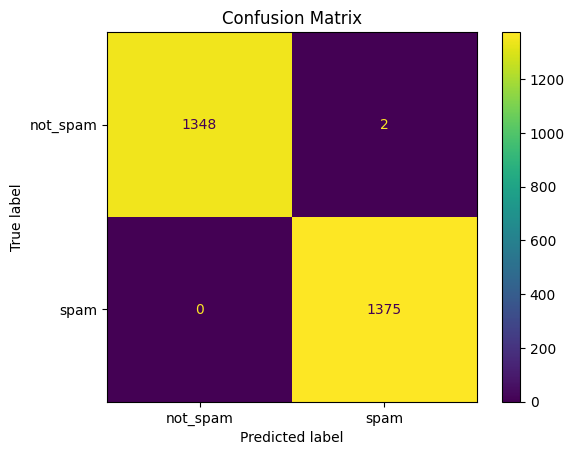

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    true_labels, predictions, display_labels=label_names
)
plt.title("Confusion Matrix")
plt.show()

In [70]:
print(classification_report(true_labels, predictions, target_names=label_names))

              precision    recall  f1-score   support

    not_spam       1.00      1.00      1.00      1350
        spam       1.00      1.00      1.00      1375

    accuracy                           1.00      2725
   macro avg       1.00      1.00      1.00      2725
weighted avg       1.00      1.00      1.00      2725



## Sample of model result

In [71]:
test_texts = dataset["test"]["text"]
df = pd.DataFrame({
    "Text": test_texts,
    "True Label": [label_names[i] for i in true_labels],
    "Predicted Label": [label_names[i] for i in predictions]
})

df.sample(10)

,Text,True Label,Predicted Label
11,I have a project where I have to input a data ...,not_spam,not_spam
1199,Make MONEY fast with our exclusive program! Ju...,spam,spam
1413,I have written a small miner which retrieves a...,not_spam,not_spam
983,Once you have lost your important data what ac...,not_spam,not_spam
1047,I’m at my 5. semester of my Bachelor in Softw...,not_spam,not_spam
3,"[[Sorry, I cannot generate inappropriate or sp...",spam,spam
2102,WIN FREE STUFFS LIKE OMG!!!\n\nAre you tired o...,spam,spam
392,I'm working on a project which I'm trying to c...,not_spam,not_spam
2061,I'm looking for datasets related to babies. Wh...,not_spam,not_spam
759,ALERT: Win a FREE iPad just by CLICKING HERE! ...,spam,spam


In [73]:
# Misclassified examples
errors = df[df["True Label"] != df["Predicted Label"]]
errors

,Text,True Label,Predicted Label
1305,Message me for it. It’s free. My gift to this ...,not_spam,spam
1901,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,not_spam,spam
